## Identifying SL paralog pairs with DepMap genome-wide CRISPR screens

**Input:**
* gene scores processed with CERES
* gene expression and mutation from the DepMap portal (20Q2)
* processed (confident) homozygous deletions + cell lines that had copy number data
* paralogs pairs from Ensembl annotated with seq id and family size
* cell line lineage from DepMap
* protein atlas tissue distribution + specificity

**Output:**
* (non-)synthetic lethal paralog pairs (our training dataset)
* Table S3: binary matrix to indicate A2 loss in each of 762 cell lines
* Table S4: full results of testing candidate paralog pairs for association between A1 dependency and A2 loss

In [50]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.formula.api as smf
import os
import re
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn2

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# DepMap/CCLE Inputs
file_gene_scores = get_local_data_path(['processed', 'depmap20Q2'], 'gene_scores_16_04_21.csv')
file_expression = get_data_path(['depmap', '20Q2'], 'CCLE_expression.csv')
file_mutations = get_data_path(['depmap', '20Q2'], 'CCLE_mutations.csv')
file_cell_lines_w_cn = get_local_data_path(['processed', 'depmap20Q2'], 'ccle_gene_cn_cell_lines.csv')
file_ccle_homdels = lambda x: get_local_data_path(['processed', 'depmap20Q2'], 'ccle_homdels_w_confidence_t='+x+'.csv')
file_sample_info = get_data_path(['depmap', '20Q2'], 'sample_info.csv')
file_sanger_gene_scores = get_local_data_path(['processed', 'sanger'], 'gene_scores_16_04_21.csv')

# Other intputs
file_protein_atlas = get_data_path(['protein_atlas'], 'proteinatlas_v19.3.tsv')
file_validate_SLs = get_local_data_path([], 'validated_SLs.txt')

# Initial input pairs to test
file_all_paralog_pairs = get_local_data_path(['processed', 'ensembl93'], 'all_pairs.csv')

# OUTPUT
file_depmap_pairs = get_local_data_path(['results'], 'depmap_pairs.csv')
file_gene_loss = get_local_data_path(['results'], 'gene_loss_df.csv')
file_full_results = get_local_data_path(['results'], 'depmap_pairs_full_results.csv')
file_table_s3 = get_local_data_path(['supplemental_files'], 'Table_S3.csv')
file_table_s4 = get_local_data_path(['supplemental_files'], 'Table_S4.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

#### CERES processed dependency scores

In [2]:
all_scores = pd.read_csv(file_gene_scores, index_col=0)

In [3]:
all_scores[:1]

,1,29974,2,144568,127550,53947,51146,8086,65985,13,...,221302,9183,55055,11130,79364,440590,79699,7791,23140,26009
ACH-000004,0.153,0.0372,-0.2442,-0.0256,-0.0196,-0.208,0.3096,-0.4438,0.2257,0.1447,...,-0.24,-0.1982,-0.132,-0.4609,0.1545,0.17,-0.4775,0.2669,0.1061,-0.2168


#### Cell line lineage

In [9]:
sample_info = pd.read_csv(file_sample_info)
sample_info = sample_info[['DepMap_ID','lineage']].rename(columns={'DepMap_ID':'cell_line'})
print('N unique lineages:', sample_info[sample_info.cell_line.isin(all_scores.index)].lineage.nunique())
sample_info[:1]

N unique lineages: 26


,cell_line,lineage
0,ACH-000001,ovary


#### Gene Expression

In [7]:
all_expr_raw = pd.read_csv(file_expression, index_col=0, sep='\t')

In [8]:
get_gene_id = lambda x: re.search('[\w-]+\s\((\w+)\)', x).group(1)
all_expr = all_expr_raw.rename(columns=get_gene_id)
all_expr[:1]

,7105,64102,8813,57147,55732,2268,3075,2519,2729,4800,...,112441429,112441438,341568,112441431,729759,110599564,6905,112577462,89839,112577461
ACH-001097,0.0,0.0,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,2.15056,...,0.0,0.0,0.0,0.0,0.0,2.980025,5.132988,0.0,0.443607,0.0


In [10]:
all_expr_zscored = all_expr.apply(lambda x: stats.zscore(x) if not (x==0).all() else 0)
all_expr_zscored[:1]

,7105,64102,8813,57147,55732,2268,3075,2519,2729,4800,...,112441429,112441438,341568,112441431,729759,110599564,6905,112577462,89839,112577461
ACH-001097,-2.098497,-0.198894,-2.659021,-1.111848,-0.22196,3.173235,-0.68515,-1.59882,-2.367321,-3.015304,...,-0.027703,0,-0.167573,-0.052889,-0.452706,-0.305474,0.598535,-0.1728,-1.805753,-0.498198


#### Mutations

In [11]:
all_mutations_raw = pd.read_csv(file_mutations, low_memory=False, sep='\t')

In [12]:
all_mutations_raw[:1]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,ExAC_AF,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID
0,A1BG,1,37,19,58858743,58858743,+,Missense_Mutation,SNP,C,...,NaN,NaN,20:16,20:16,NaN,NaN,NaN,NaN,other non-conserving,ACH-000986


In [13]:
mut_cell_lines = all_mutations_raw.DepMap_ID.unique()
lof_vars = ['Splice_Site', 'Nonsense_Mutation', 'Frame_Shift_Del', 'Frame_Shift_Ins', 'De_novo_Start_OutOfFrame']
lof_mutations = all_mutations_raw[all_mutations_raw.Variant_Classification.isin(lof_vars)]
lof_mutations = lof_mutations.rename(columns={'Entrez_Gene_Id':'entrez_id','DepMap_ID':'cell_line'})
lof_mutations = lof_mutations[['entrez_id','Hugo_Symbol','Variant_Classification','cell_line']].astype({'entrez_id':'str'})
display(lof_mutations.Variant_Classification.value_counts())
lof_mutations[:1]

Splice_Site                 43468
Frame_Shift_Del             42362
Nonsense_Mutation           40796
Frame_Shift_Ins             24744
De_novo_Start_OutOfFrame     4565
Name: Variant_Classification, dtype: int64

,entrez_id,Hugo_Symbol,Variant_Classification,cell_line
32,1,A1BG,Nonsense_Mutation,ACH-000983


#### Homozygous Deletions
Restrict to confident HDs - those supported by change in expression

In [14]:
# Get copy number data to compute overlapping cell lines
copy_num_cell_lines = pd.read_csv(file_cell_lines_w_cn)
display(copy_num_cell_lines[:1])

,cell_line
0,ACH-000001


In [15]:
homdels = {}
for t in ['-1.28','-1.5']:
    df = pd.read_csv(file_ccle_homdels(t))
    df = df[df.confident].reset_index().rename(columns={'depMapID':'cell_line'}).astype({'entrez_id':'str'})
    homdels[t] = df
    print('Genes with confident HDs, t=%s: %d'% (t, df.entrez_id.nunique()))
homdels['-1.28'][:1]

Genes with confident HDs, t=-1.28: 3131
Genes with confident HDs, t=-1.5: 1668


,index,cell_line,entrez_id,pval,tstat,del_expr,other_expr,num_homdels,confident
0,0,ACH-000001,101060226,0.00049,-3.495222,2.015343,2.611616,22,True


#### Protein atlas tissue specificity + distribution

In [16]:
protein_atlas = pd.read_csv(file_protein_atlas, sep='\t')
protein_atlas = protein_atlas[['Ensembl', 'Gene', 'RNA tissue specificity', 'RNA tissue distribution']]
protein_atlas[:2]

,Ensembl,Gene,RNA tissue specificity,RNA tissue distribution
0,ENSG00000000003,TSPAN6,Tissue enhanced,Detected in many
1,ENSG00000000005,TNMD,Tissue enhanced,Detected in many


### Load all paralog pairs

In [17]:
# Load all paralog pairs from Ensembl
def load_all_paralog_pair(fname):
    all_pairs = pd.read_csv(fname)
    all_pairs = all_pairs.astype({'A1_entrez':'str', 'A2_entrez':'str'})
    all_pairs['sorted_gene_pair'] = all_pairs.apply(lambda x: '_'.join(sorted([x.A1, x.A2])), axis=1)
    print('Protein coding pairs:', all_pairs.sorted_gene_pair.nunique())
    print('Protein coding pairs min. 20% (reciprocal) & family size < 20:', 
          all_pairs[(all_pairs.min_seq_id>=0.2) & (all_pairs.family_size<20)].sorted_gene_pair.nunique())
    # Just keep relevent columns for this analysis
    all_pairs = all_pairs[['sorted_gene_pair','A1','A2','A1_ensembl','A2_ensembl','A1_entrez','A2_entrez',
                                           'min_seq_id', 'family_size']]
    return all_pairs

In [18]:
all_paralog_pairs = load_all_paralog_pair(file_all_paralog_pairs)
all_paralog_pairs[:1]

Protein coding pairs: 36648
Protein coding pairs min. 20% (reciprocal) & family size < 20: 23332


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,min_seq_id,family_size
0,TEKT2_TEKT4,TEKT2,TEKT4,ENSG00000092850,ENSG00000163060,27285,150483,0.289655,5


### Identify gene pairs where loss of 1 results in significant increase/decrease of essentiality of the other


Candidate pairs to test:
* Min seq id >= 20%
* Family size <= 20
* A1 and A2 are broadly expressed:
    - RNA tissue distribution = 'Detected in all' OR
    - RNA tissue distribution = 'Detected in many' AND RNA tissue specificity = Low specificity', 'Not detected'
* A1 is in CERES scores data frame
* A2 lost in min. 10 (max 90%) cell lines

A2 loss:
* gene expression log(TPM+1) < 1
* gene expression z-score < -4
* LOF mutation
* homozygous deletion supported by change in expression

In [19]:
# Filter on data availability, seq id, family size and protein atlas filter
def apply_first_filter(all_pairs, scores, protein_atlas_filter):
    pairs_to_test = all_pairs[(all_pairs.min_seq_id >= 0.2) & (all_pairs.family_size <= 20) &
                              all_pairs.A1_entrez.isin(scores.columns) & 
                              all_pairs.A2_entrez.isin(all_expr.columns) & 
                              all_pairs.A1_ensembl.isin(protein_atlas_filter.Ensembl) &
                              all_pairs.A2_ensembl.isin(protein_atlas_filter.Ensembl)].reset_index(drop=True)
    print('Num pairs to test: %d/%d -> unique: %d/%d' % (pairs_to_test.shape[0], all_pairs.shape[0],
          pairs_to_test.sorted_gene_pair.nunique(), all_pairs.sorted_gene_pair.nunique()))
    return pairs_to_test

expr_func = lambda x, t: x < t if t>0 else x==t

# Call gene loss for 1 gene based on expr, mutation and homdels, called by apply_second_filter 
def call_gene_loss(gene, homdels, expr_t, exprz_t):
    A2_expr = all_expr.loc[:, gene.name]
    A2_expr_z = all_expr_zscored.loc[:, gene.name]
    return pd.Series(gene.index.isin(A2_expr[expr_func(A2_expr, expr_t)].index) |
                     gene.index.isin(A2_expr_z[A2_expr_z < exprz_t].index) |
                     gene.index.isin(lof_mutations[lof_mutations.entrez_id==gene.name].cell_line) |
                     gene.index.isin(homdels[homdels.entrez_id==gene.name].cell_line), index=gene.index)

# Filter to pairs lost in at least 10 and max 90% of cell lines
def apply_second_filter(all_pairs, scores, homdels, expr_t, exprz_t):
    # Create empty df to fill in
    A2_loss_df = pd.DataFrame(index=all_pairs.A2_entrez.unique(), columns=sorted(scores.index.values))
    # Binary matrix for gene loss in each cell line (1=loss, 0=WT)
    A2_loss_df = A2_loss_df.apply(call_gene_loss, args=(homdels, expr_t, exprz_t), axis=1)
    # Only test pairs where A2 is lost in min. 10 and max 90% of cell lines
    A2_loss_summary = A2_loss_df.sum(axis=1).reset_index().rename(columns={'index':'A2_entrez', 0:'n_A2_lost'})
    pairs = pd.merge(all_pairs, A2_loss_summary)
    # Filter
    pairs_to_test = pairs[(pairs.n_A2_lost >= 10) & (pairs.n_A2_lost <= (scores.shape[0]*0.9))] 
    print('Num pairs to test after loss filter: %d/%d -> unique: %d/%d' % (pairs_to_test.shape[0], all_pairs.shape[0],
          pairs_to_test.sorted_gene_pair.nunique(), all_pairs.sorted_gene_pair.nunique()))
    return pairs_to_test, A2_loss_df

# Test whether there is a significant difference in dependency score of A1 when A2 is/is not lost
def test_A1_score_for_A2_loss_vs_wt(pair, scores, gene_loss_df):
    # A1 score for each cell line
    A1_scores = scores.loc[:, pair.A1_entrez].reset_index().rename(columns={pair.A1_entrez:'A1_score'})
    # A2 loss (T/F) for each cell line
    A2_loss = gene_loss_df.loc[pair.A2_entrez,:].reset_index().rename(columns={'index':'cell_line', pair.A2_entrez:'A2_loss'})
    # Merge score, loss status, cell line lineage
    df = pd.merge(pd.merge(A1_scores, A2_loss), sample_info)
    # Linear model
    ols_results = smf.ols('A1_score ~ C(lineage) + C(A2_loss)', data=df).fit()
    ols_pval = ols_results.pvalues['C(A2_loss)[T.True]']
    ols_coef = ols_results.params['C(A2_loss)[T.True]']
    result = pd.Series([ols_pval, ols_coef, df[df.A2_loss].A1_score.mean(), df[~df.A2_loss].A1_score.mean()], 
                       index=['ols_p', 'ols_coef','A2_loss_mean_score', 'A2_wt_mean_score'])
    return pair.append(result)

# This function returns the raw regression results (not FDR corrected)
def run_depmap_pipeline(all_candidates, scores_filtered, protein_atlas_filter, homdels, expr_t, exprz_t):
    candidates = apply_first_filter(all_candidates, scores_filtered, protein_atlas_filter)
    candidates, gene_loss_df = apply_second_filter(candidates, scores_filtered, homdels, expr_t, exprz_t)
    raw_results = candidates.apply(test_A1_score_for_A2_loss_vs_wt, args=(scores_filtered, gene_loss_df), axis=1)
    return raw_results, gene_loss_df

#### General pipeline inputs

In [20]:
# Use scores for cell lines that were included in expr + mutation + copy number data sets
scores_filtered = all_scores.loc[all_scores.index.isin(all_expr.index) & all_scores.index.isin(mut_cell_lines) &
                                 all_scores.index.isin(copy_num_cell_lines.cell_line), :]
scores_filtered.index.name = 'cell_line'
print('Cell lines to use:', scores_filtered.shape[0], '/', all_scores.shape[0])

# Filter for genes that are broadly expressed (not tissue specific)
protein_atlas_filter = protein_atlas[protein_atlas['RNA tissue distribution'].isin(['Detected in all']) |
                                     (protein_atlas['RNA tissue distribution'].isin(['Detected in many']) &
                                      protein_atlas['RNA tissue specificity'].isin(['Low tissue specificity','Not detected']))]

Cell lines to use: 762 / 769


#### Run pipeline

In [21]:
raw_results, gene_loss_df = run_depmap_pipeline(all_paralog_pairs, scores_filtered, protein_atlas_filter,
                                                homdels['-1.28'], expr_t=1, exprz_t=-4)

Num pairs to test: 9633/73296 -> unique: 5270/36648
Num pairs to test after loss filter: 5205/9633 -> unique: 3810/5270


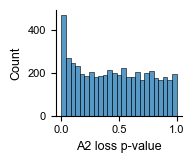

In [24]:
# Plot distribution of p-values
f, ax = plt.subplots(1, 1, figsize=(2,1.7), sharey=False)
sns.histplot(x=raw_results.ols_p, ax=ax, bins=25); ax.set_xlabel('A2 loss p-value')
plt.tight_layout()

In [25]:
# Save A2 loss binary matrix
gene_loss_df.to_csv(file_gene_loss)

#### Supplemental table for paper (gene loss df)

In [26]:
# Save A2 lost dataframe, for just the final set of candidate pairs, as binary matrix table S3
table_s3 = gene_loss_df[gene_loss_df.index.isin(raw_results.A2_entrez)].astype(int)
print('N. unique A2s:', table_s3.shape[0])
assert(table_s3.shape[0] == raw_results.A2_entrez.nunique())
display(table_s3[:1])
table_s3.to_csv(file_table_s3)

N. unique A2s: 2331


,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-001960,ACH-001997,ACH-001999,ACH-002001,ACH-002002,ACH-002003,ACH-002004,ACH-002005,ACH-002015,ACH-002016
5431,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Process raw results: FDR correction + calling SLs

In [27]:
# Check how many potential SL pairs there are, and whether they include previously validated SL pairs
validated_SLs = pd.read_csv(file_validate_SLs)
validated_SLs['sorted_gene_pair'] = validated_SLs.apply(lambda x: '_'.join(sorted([x.A1, x.A2])), axis=1)
print('N. previously validated SL paralog pairs:', validated_SLs.shape[0])

def check_SLs(results, verbose=False):
    if results.shape[0] != results.sorted_gene_pair.nunique():
        print('All SL pairs: %d / %d = %.2f%%' % 
              (results[results.SL].shape[0], results.shape[0], (results[results.SL].shape[0] / results.shape[0]*100)))
    print('Unique SL pairs: %d / %d = %.2f%%' % 
          (results[results.SL].sorted_gene_pair.nunique(), results.sorted_gene_pair.nunique(), 
           (results[results.SL].sorted_gene_pair.nunique() / results.sorted_gene_pair.nunique()*100)))
    # Merge with known SLs (nan if not tested)
    overlap = pd.merge(results.groupby('sorted_gene_pair').SL.max().reset_index(), validated_SLs, how='right')
    print('Known SLs retrieved:', sum(overlap.SL==True))
    if verbose:
        for i, row in overlap.iterrows():
            if row.SL==True: continue
            if row.SL==False: print(row.sorted_gene_pair,': not SL', sep='')
            else: print(row.sorted_gene_pair,': not tested', sep='')

N. previously validated SL paralog pairs: 12


In [28]:
def process_results(raw_results, scores, score_t):
    A1_essentiality = ((scores < score_t).sum() > 0).reset_index().rename(columns={'index':'A1_entrez', 0:'A1_ess'})
    df = pd.merge(raw_results, A1_essentiality)
    sometimes_essential = df[df.A1_ess].reset_index(drop=True)
    never_essential = df[df.A1_ess==False].reset_index(drop=True)
    
    # FDR correction for pairs that are essential in at least 1 cell line
    results = sometimes_essential.assign(p_adj = fdrcorrection(sometimes_essential.ols_p.values)[1])
    
    # SL if FDR < 10% + A2_loss coefficient is negative (associated with decrease in CERES score)
    results = results.assign(
        SL = results.apply(lambda x: ((x.p_adj < 0.1) & (x.ols_coef < 0)), axis=1),
        nearly_SL = results.apply(lambda x: ((x.ols_p < 0.05) & (x.p_adj > 0.1) & (x.ols_coef < 0)), axis=1))
    
    # Directly mark pairs that are never essential as not SL
    results = pd.concat([results, never_essential]).reset_index(drop=True).fillna({'SL':False, 'nearly_SL':False})
    
    # Re-order columns + sort
    results = results[['A1','A2','sorted_gene_pair','SL','nearly_SL','ols_p','ols_coef','p_adj','n_A2_lost',
                       'A2_loss_mean_score','A2_wt_mean_score','A1_ess','A1_entrez','A2_entrez']]
    results = results.sort_values('p_adj').reset_index(drop=True)
    assert(results.shape[0]==raw_results.shape[0])
    
    # Unique results (call a pair SL if it was SL in either direction)
    unique_pairs = results.groupby('sorted_gene_pair').agg({'SL':'max', 'nearly_SL':'max'}).reset_index()
    # Drop nearly SL pairs (p<0.05)
    unique_pairs = unique_pairs[(unique_pairs.SL)|(~unique_pairs.nearly_SL)].reset_index(drop=True).drop(columns=['nearly_SL'])
    
    return results, unique_pairs

In [29]:
results, depmap_pairs = process_results(raw_results, scores_filtered, score_t=-0.6)
check_SLs(results)
results[:1]

All SL pairs: 131 / 5205 = 2.52%
Unique SL pairs: 126 / 3810 = 3.31%
Known SLs retrieved: 6


,A1,A2,sorted_gene_pair,SL,nearly_SL,ols_p,ols_coef,p_adj,n_A2_lost,A2_loss_mean_score,A2_wt_mean_score,A1_ess,A1_entrez,A2_entrez
0,RPP25L,RPP25,RPP25_RPP25L,True,False,5.610660e-116,-0.661964,2.093898e-112,166,-0.876807,-0.135491,True,138716,54913


In [30]:
results.to_csv(file_full_results, index=0)

In [31]:
check_SLs(depmap_pairs)

Unique SL pairs: 126 / 3634 = 3.47%
Known SLs retrieved: 6


In [32]:
depmap_pairs.to_csv(file_depmap_pairs, index=0)

In [33]:
# Save full results as Table S4
table_s4 = results[['sorted_gene_pair','A1','A2','ols_coef','ols_p','p_adj','SL','nearly_SL','A1_entrez','A2_entrez']]
table_s4 = table_s4.rename(columns={'ols_coef':'A2_status_coef', 'ols_p':'A2_status_p', 'p_adj':'A2_status_p_adj'})

# Set SL to NA if pair is nearly_SL
table_s4['SL'] = table_s4.apply(lambda x: float('nan') if x.nearly_SL else x.SL, axis=1)
# Add in ensembl ids
table_s4 = pd.merge(table_s4, all_paralog_pairs[['A1','A2','A1_ensembl','A2_ensembl']])
table_s4 = table_s4.sort_values(['sorted_gene_pair']).drop(columns=['nearly_SL']).reset_index(drop=True)

assert(table_s4.shape[0] == results.shape[0])
assert(sum(table_s4.SL==True) == sum(results.SL==True))
assert(table_s4.shape[0]==5205)
display(table_s4[:3])
table_s4.to_csv(file_table_s4, index=0)

,sorted_gene_pair,A1,A2,A2_status_coef,A2_status_p,A2_status_p_adj,SL,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl
0,AAK1_BMP2K,AAK1,BMP2K,-0.033329,0.445594,0.873493,False,22848,55589,ENSG00000115977,ENSG00000138756
1,AAK1_BMP2K,BMP2K,AAK1,-0.059093,0.083675,NaN,False,55589,22848,ENSG00000138756,ENSG00000115977
2,ABCA1_ABCA7,ABCA1,ABCA7,-0.000183,0.995204,0.998303,False,19,10347,ENSG00000165029,ENSG00000064687


### Validate with Sanger CRISPR scores
Re-test SL and non-SL pairs identified in the DepMap Broad analysis.  

In [35]:
# Load sanger scores
all_sanger_scores = pd.read_csv(file_sanger_gene_scores, index_col=0)

In [36]:
print('N cell lines:', all_sanger_scores.shape[0])
# Use scores for cell lines that were included in expr + mutation + copy number data sets
sanger_scores = all_sanger_scores.loc[all_sanger_scores.index.isin(all_expr.index) & 
                                      all_sanger_scores.index.isin(mut_cell_lines) &
                                      all_sanger_scores.index.isin(copy_num_cell_lines.cell_line), :]
sanger_scores.index.name = 'cell_line'
print('Cell lines that can be used:', sanger_scores.shape[0], '/', all_sanger_scores.shape[0])
print('N unique cell lines:', sanger_scores.loc[~sanger_scores.index.isin(all_scores.index), :].shape[0])
sanger_scores[:1]

N cell lines: 318
Cell lines that can be used: 242 / 318
N unique cell lines: 66


,1,29974,2,144568,127550,53947,51146,8086,65985,13,...,221302,9183,55055,11130,79364,440590,79699,7791,23140,26009
cell_line,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.4023,-0.2299,0.0824,-0.1455,-0.2633,0.0796,-0.2734,-0.1899,0.0009,0.1111,...,-0.008,-0.2627,-0.2008,-0.3151,0.1414,-0.2695,-0.0225,0.134,0.1329,-0.5369


In [37]:
# Test DepMap Broad SLs and non-SL pairs symmetrically
SL_pairs = all_paralog_pairs[all_paralog_pairs.sorted_gene_pair.isin(depmap_pairs[depmap_pairs.SL].sorted_gene_pair)]
assert(SL_pairs.shape[0] == sum(depmap_pairs.SL)*2)
print('N SL to test (symmetric):', SL_pairs.shape[0])
nSL_pairs = all_paralog_pairs[all_paralog_pairs.sorted_gene_pair.isin(depmap_pairs[~depmap_pairs.SL].sorted_gene_pair)]
print('N non-SL to test (symmetric):', nSL_pairs.shape[0])

N SL to test (symmetric): 252
N non-SL to test (symmetric): 7016


In [38]:
raw_results_SL,_ = run_depmap_pipeline(SL_pairs, sanger_scores, protein_atlas_filter, homdels['-1.28'], expr_t=1, exprz_t=-4)
results_SL,_ = process_results(raw_results_SL, sanger_scores, score_t=-0.6)
check_SLs(results_SL)

Num pairs to test: 230/252 -> unique: 126/126
Num pairs to test after loss filter: 108/230 -> unique: 93/126
All SL pairs: 47 / 108 = 43.52%
Unique SL pairs: 44 / 93 = 47.31%
Known SLs retrieved: 5


In [39]:
raw_results_nSL,_ = run_depmap_pipeline(nSL_pairs, sanger_scores, protein_atlas_filter, homdels['-1.28'], expr_t=1, exprz_t=-4)
results_nSL,_ = process_results(raw_results_nSL, sanger_scores, score_t=-0.6)
check_SLs(results_nSL)

Num pairs to test: 6483/7016 -> unique: 3493/3508
Num pairs to test after loss filter: 3279/6483 -> unique: 2580/3493
All SL pairs: 0 / 3279 = 0.00%
Unique SL pairs: 0 / 2580 = 0.00%
Known SLs retrieved: 0


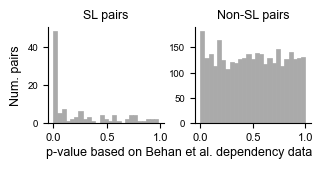

In [62]:
# Plot distribution of raw p-values
f, ax = plt.subplots(1, 2, figsize=(3.3,1.6))
histkws = {'edgecolor':'#aaa', 'alpha':1, 'linewidth':0.5, 'bins':25, 'color':'#aaa'}
sns.histplot(raw_results_SL.ols_p, ax=ax[0], **histkws)
sns.histplot(raw_results_nSL.ols_p, ax=ax[1], **histkws)
ax[0].set_title('SL pairs', fontsize=9); ax[1].set_title('Non-SL pairs', fontsize=9)
ax[0].set_ylabel('Num. pairs', fontsize=9); ax[1].set_ylabel('')
ax[0].set_xlabel(''); ax[1].set_xlabel('')
f.text(0.15,0, "p-value based on Behan et al. dependency data")
for i in ax[0].get_yticklabels(): i.set_fontsize(7)
for i in ax[1].get_yticklabels(): i.set_fontsize(7)
plt.tight_layout(w_pad=0.1)
#f.savefig('../figures/for_paper/sanger_pvals.svg', bbox_inches='tight', dpi=300)

### Visualization of Individual Pairs
Requires scores + A2_lost df + full results

In [40]:
# gene_loss_df = pd.read_csv(file_gene_loss, index_col=0)
# gene_loss_df.index = gene_loss_df.index.astype('str')

In [41]:
# scores_filtered = all_scores[all_scores.index.isin(gene_loss_df.columns)]

In [42]:
results = pd.read_csv(file_full_results).astype({'A1_entrez':'str', 'A2_entrez':'str'})

In [43]:
def box_plot_for_pair(A1, A2, ax, scores=scores_filtered, gene_loss=gene_loss_df, show_points=True):
    pair = results.loc[(results.A1==A1) & (results.A2==A2),:].iloc[0]
    df = scores.loc[:, pair.A1_entrez].reset_index().rename(columns={'index':'cell_line', pair.A1_entrez:'A1_score'})
    A2_status = gene_loss.loc[pair.A2_entrez,:].reset_index().rename(columns={'index':'cell_line', pair.A2_entrez:'A2_loss'})
    df = pd.merge(df, A2_status)
    df.A2_loss = df.A2_loss.apply(lambda x: ('Loss' if x else 'WT'))
    df = df.sort_values('A2_loss', ascending=False)
    sns.boxplot(y='A1_score', x='A2_loss', data=df, palette=['white', "#56B4E9"], ax=ax, linewidth=0.98, 
                showfliers=False, showmeans=False, saturation=1, boxprops=dict(alpha=0.5, edgecolor='black'), 
                medianprops=dict(linewidth=1, color='black'))
    if show_points:
        sns.stripplot(y='A1_score', x='A2_loss', data=df, color='grey', ax=ax, alpha=0.7, size=2, zorder=0)
        ax.set_xlabel(pair.A2, fontstyle='italic'); ax.set_ylabel(A1+ ' dependency')
        draw_signif_line(ax, 0, 1, df.A1_score.max()+0.05, pair.p_adj)
    gp.set_axis_props(ax, show_top_spine=False, show_right_spine=False, show_xticks=False, show_yticks=False,
                      xtick_fontsize=9, ytick_fontsize=8)
    
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    h = y/hd
    if pval < 0.0001: txt = '$p$=%.1e' % pval 
    else: txt = '$p$=%.4f' % pval 
    ax.plot([x0, x0, x1, x1], [y+h, y+2*h, y+2*h, y+h], lw=1, c='#666')
    ax.text((x0+x1)*.5, y+2.5*h, txt, ha='center', va='bottom', color='#666', fontsize=8)

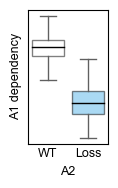

In [45]:
f, ax = plt.subplots(1, 1, figsize=(1.25,1.95))
box_plot_for_pair('RPP25L', 'RPP25', ax, show_points=False)
gp.set_axis_props(ax, show_xticks=False, xtick_fontsize=9, xlabel='A2', ylabel='A1 dependency', show_yticklabels=False,
                  show_top_spine=True, show_right_spine=True)
plt.tight_layout()
f.savefig('../figures/for_paper/boxplot_example.svg', bbox_inches='tight', dpi=300, transparent=True)

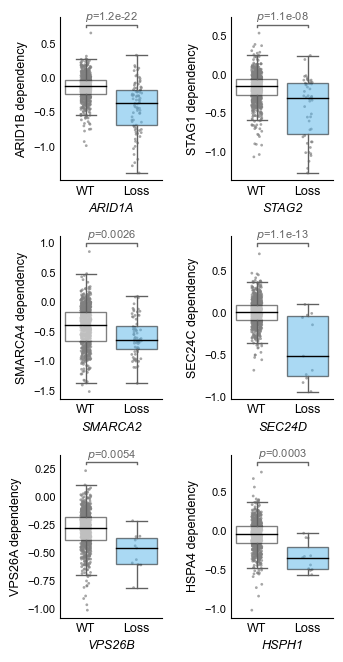

In [46]:
f, ax = plt.subplots(3, 2, figsize=(3.5,6.7))
ax = ax.flatten()
box_plot_for_pair('ARID1B', 'ARID1A', ax[0])
box_plot_for_pair('STAG1', 'STAG2', ax[1])
box_plot_for_pair('SMARCA4', 'SMARCA2', ax[2])
box_plot_for_pair('SEC24C', 'SEC24D', ax[3])
box_plot_for_pair('VPS26A', 'VPS26B', ax[4])
box_plot_for_pair('HSPA4', 'HSPH1', ax[5])
plt.tight_layout(h_pad=1, w_pad=2)
f.savefig('../figures/for_paper/boxplot_example_SLs.svg', bbox_inches='tight', dpi=300)

### Re-run pipeline with alternative thresholds for gene loss / essentiality

In [47]:
file_alt_depmap_pairs = lambda expr_t, exprz_t, hdt, ess: get_local_data_path(['results','alt_params'], 
                                'depmap_pairs_expr='+str(expr_t)+'_exprz='+str(exprz_t)+'_hd='+str(hdt)+'_ess='+str(ess))

In [48]:
# Thresholds for expression, expression z-score and copy number (HD)
thresholds = [[0.17,1],[-3,-4,-6],[-1.28,-1.5]]

In [52]:
for params in list(itertools.product(*thresholds)):
    print(params)
    raw_results_, _ = run_depmap_pipeline(all_paralog_pairs, scores_filtered, protein_atlas_filter,
                                          homdels[str(params[2])], expr_t=params[0], exprz_t=params[1])
    # Thresholds for essentiality
    for score_t in [-0.5,-0.6,-0.7]:
        results_, unique_results_ = process_results(raw_results_, scores_filtered, score_t=score_t)
        check_SLs(unique_results_)
        unique_results_.to_csv(file_alt_depmap_pairs(params[0],params[1],params[2],score_t), index=0)

(0.17, -3, -1.28)
Num pairs to test: 9633/73296 -> unique: 5270/36648
Num pairs to test after loss filter: 4731/9633 -> unique: 3600/5270
Unique SL pairs: 88 / 3411 = 2.58%
Known SLs retrieved: 6
Unique SL pairs: 91 / 3429 = 2.65%
Known SLs retrieved: 6
Unique SL pairs: 91 / 3456 = 2.63%
Known SLs retrieved: 6
(0.17, -3, -1.5)
Num pairs to test: 9633/73296 -> unique: 5270/36648
Num pairs to test after loss filter: 4410/9633 -> unique: 3371/5270
Unique SL pairs: 79 / 3201 = 2.47%
Known SLs retrieved: 6
Unique SL pairs: 82 / 3218 = 2.55%
Known SLs retrieved: 6
Unique SL pairs: 86 / 3240 = 2.65%
Known SLs retrieved: 6
(0.17, -4, -1.28)
Num pairs to test: 9633/73296 -> unique: 5270/36648
Num pairs to test after loss filter: 4116/9633 -> unique: 3213/5270
Unique SL pairs: 66 / 3055 = 2.16%
Known SLs retrieved: 6
Unique SL pairs: 66 / 3069 = 2.15%
Known SLs retrieved: 6
Unique SL pairs: 70 / 3090 = 2.27%
Known SLs retrieved: 6
(0.17, -4, -1.5)
Num pairs to test: 9633/73296 -> unique: 5270/36